In [1]:
import os
import sys
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("../")  # for utils
sys.path.append("../section4-N=50k/")  # the appendix is based on the 50k sample training
from util import sns_config, matplot_config, tex_config, Baseline, aggregated_losses_for_model

sns.set_style("whitegrid", sns_config)
matplotlib.rcParams.update(matplot_config)

baseline = Baseline(path="../section3-baseline/baseline_k.csv")
df = pd.read_csv("../section4-N=50k/50k_history_v2.csv")
df

,model,dataset,loss,epoch,polarity_mean,semantic_mean
0,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,1,66.541,41.155
1,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,2,67.275,40.589
2,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,3,67.968,40.264
3,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,4,68.594,40.044
4,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,5,68.978,39.852
...,...,...,...,...,...,...
675,gte-base,sst2,TripletLoss,1,87.952,83.035
676,gte-base,sst2,TripletLoss,2,89.278,82.520
677,gte-base,sst2,TripletLoss,3,89.579,82.152
678,gte-base,sst2,TripletLoss,4,90.023,82.005


In [2]:
df = df.rename(columns=lambda x: x.replace("_mean", ""))
df

,model,dataset,loss,epoch,polarity,semantic
0,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,1,66.541,41.155
1,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,2,67.275,40.589
2,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,3,67.968,40.264
3,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,4,68.594,40.044
4,minilm-6,sarcastic-headlines,MultipleNegativesRankingLoss,5,68.978,39.852
...,...,...,...,...,...,...
675,gte-base,sst2,TripletLoss,1,87.952,83.035
676,gte-base,sst2,TripletLoss,2,89.278,82.520
677,gte-base,sst2,TripletLoss,3,89.579,82.152
678,gte-base,sst2,TripletLoss,4,90.023,82.005


In [3]:
baseline.baseline_df

,dataset,model,k,p_mean,p_std,s_mean,s_std
2,sst2,gte-base,16,80.376,22.561,83.700,1.436
7,sst2,gte-small,16,77.774,22.204,84.808,1.410
12,sst2,e5-small,16,81.465,23.696,85.516,1.735
17,sst2,minilm-6,16,63.016,21.877,46.594,7.426
22,sarcastic-headlines,gte-base,16,67.402,20.737,81.366,1.641
27,sarcastic-headlines,gte-small,16,66.826,20.573,82.468,1.629
32,sarcastic-headlines,e5-small,16,71.436,21.241,83.404,1.463
37,sarcastic-headlines,minilm-6,16,63.751,20.178,42.307,5.615


minilm-6


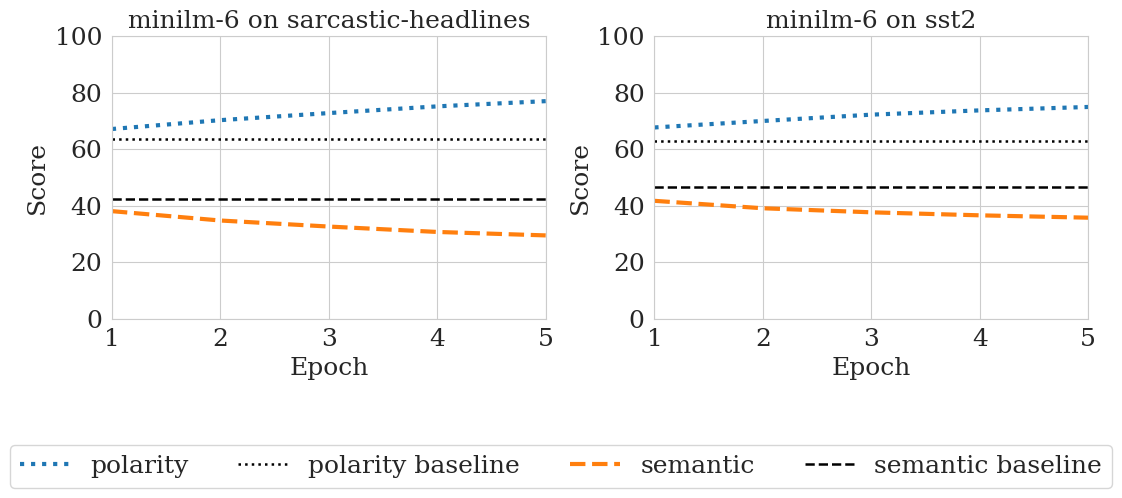

e5-small


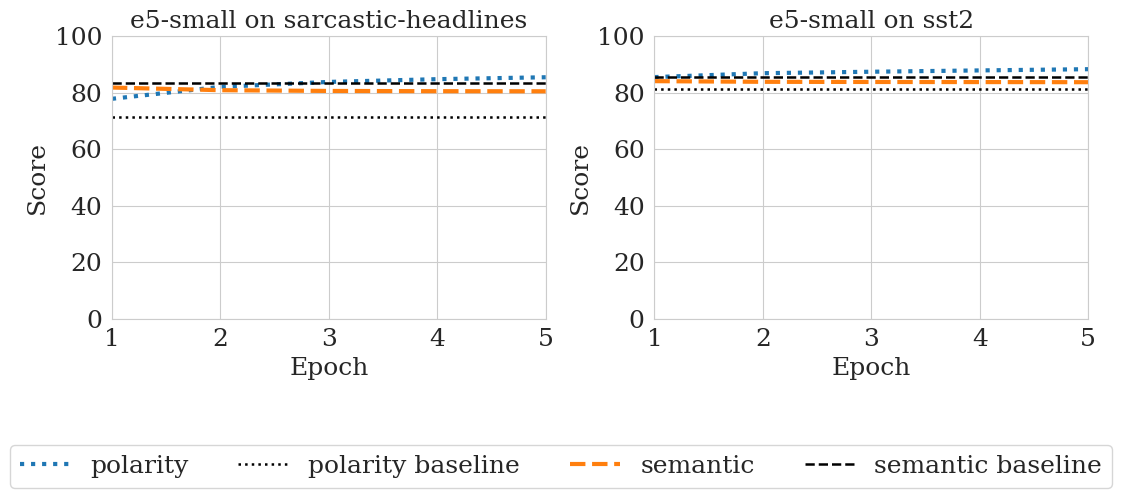

gte-small


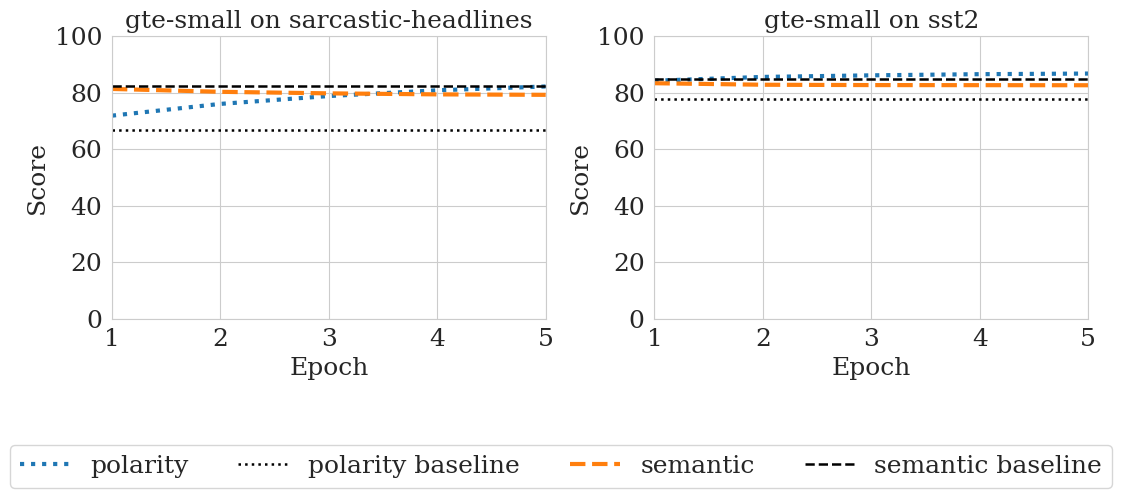

gte-base


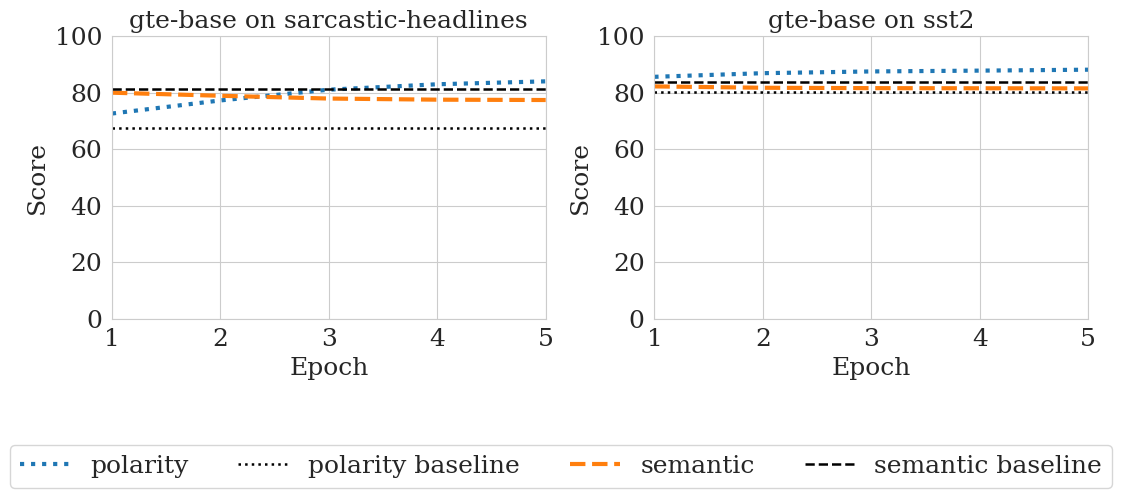

In [4]:
save_latex = False
if save_latex:
    matplotlib.use("pgf")
    matplotlib.rcParams.update(tex_config)

datasets = df.dataset.unique()
for model in df.model.unique():
    print(model)
    _df = aggregated_losses_for_model(df, model, drop=["dataset"])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,4))

    min_y = _df[["polarity", "semantic"]].min().min() - 0.05
    max_y = _df[["polarity", "semantic"]].max().max() + 0.05

    for i, dataset in enumerate(datasets):
        ax = axes[i]
        ax.set_xlim(1, 5)
        ax.set_xticks([i for i in range(1, 5+1)])
        ax.set_title(f"{model} on {dataset}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Score")
        # ax.set_ylim(min_y, max_y)
        ax.set_ylim(0, 100)

        data_format = [
            ("polarity", "dotted"),
            ("semantic", "dashed"),
        ]
        for metric, linestyle in data_format:
            __df = _df[_df.dataset == dataset]
            sns.lineplot(data=__df, x="epoch", y=f"{metric}", ax=ax, label=metric, legend=False, linestyle=linestyle, errorbar=None)

            baseline_val = baseline.get(model=model, dataset=dataset, metric="p_mean" if metric == "polarity" else "s_mean")
            if baseline_val:
                ax.plot([1, 5], [baseline_val, baseline_val], linestyle=linestyle, color="black", alpha=1, linewidth=1.8, label=f"{metric} baseline")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4, borderaxespad=-2)
    plt.tight_layout()
    if save_latex:
        folder = "figures/aggregated_losses"
        os.makedirs(folder, exist_ok=True)
        fig.savefig(f"{folder}/{model}.pgf", format="pgf", bbox_inches="tight")
    plt.show()